In [1]:
import torch.nn as nn
import numpy as np
import requests
import logging
import base64
import random
import torch
import glob
import time
import json
import cv2
import os
import sys

from io import BytesIO
from PIL import Image

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.projects.point_rend import ColorAugSSDTransform, add_pointrend_config
from torchvision import transforms
import torchvision.models as models
import copy
from shapely.geometry import Polygon
import fiftyone as fo
import fiftyone.zoo as foz

import matplotlib.pyplot as plt

def read_json(path):
    if os.path.isfile(path):
        with open(path) as f:
            data = json.load(f)
        return data
    else:
        return None

In [2]:
class SegmentationInference:
    def __init__(self, model_path,config, device='cpu', 
                 config_path="COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",  
                 labels_list = ['Fish']):
        self.model_path = model_path
        self.labels_list = labels_list
        self.model_path = model_path
        
        self.cfg = get_cfg()
        add_pointrend_config(self.cfg)
        self.cfg.merge_from_file(config)
        self.cfg.DATALOADER.NUM_WORKERS = 2
        self.cfg.MODEL.POINT_HEAD.NUM_CLASSES = 1
        self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
        
        self.cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.65
        self.cfg.MODEL.DEVICE = device
        self.cfg.MODEL.WEIGHTS = self.model_path
        self.cfg.freeze()
        self.model = DefaultPredictor(self.cfg)
        self.approximate_value = 0.0004

    def __NMS(self, polygons, poly):
        for poly_id_a in range(len(polygons) - 1, -1, -1):
            iou = get_iou_poly(polygons[poly_id_a], poly)
            if iou > 0.5:
                return True
        return False

    def __approximate(self, output):
        meta_data = {
            'polygons'    : [],
            'scores'      : [],
            'areas'       : [],
            'labels_list' : []
        }
        poly_instances = []
        
        logging.info("Aproxiame: {}".format(self.approximate_value))
        
        polygons_tmp = []

        for z in range(len(output['instances'])):
            masks = np.array(output['instances'].get('pred_masks')[z].to('cpu'))
            imgUMat = np.array(masks * 255, dtype=np.uint8)
            cnts, hierarchy = cv2.findContours(imgUMat, 1, 2)
            cnts = sorted(cnts, key=lambda x: cv2.contourArea(x))
            
            if len(cnts) == 0:
                continue
            cnts_s = cnts[len(cnts) - 1]
            epsilon = self.approximate_value * cv2.arcLength(cnts_s, True)
            approx = cv2.approxPolyDP(cnts_s, epsilon, True)
            polygons_dict = {}
            if len(approx) < 10:
                continue
            try:
                poly_tmp = Polygon([(int(approx[point_id][0][0]), int(approx[point_id][0][1])) for point_id in range(len(approx))])
            except Exception as e:
                print("Error! ", e)

            x = []
            y = []
            polygons_dict = {}
            for i in range(len(approx)):
                x.append(int(approx[i][0][0]))
                y.append(int(approx[i][0][1]))
                polygons_dict.update({
                    "x{}".format(i + 1): int(approx[i][0][0]),
                    "y{}".format(i + 1): int(approx[i][0][1])
                })
             
            meta_data['polygons'].append(polygons_dict)
            meta_data['scores'].append(float(np.array(output['instances'].get('scores')[z].to('cpu'))))
            meta_data['areas'].append(float(cv2.contourArea(cnts_s)))
            meta_data['labels_list'].append(self.labels_list[int(output['instances'][z].pred_classes[0])])
            poly_instances.append([poly_tmp, poly_tmp.area, len(meta_data['polygons']) - 1])
        
        poly_instances.sort(key=lambda x: x[1])
        index_to_remove = []
        for poly_id_a in range(len(poly_instances) -1, -1, -1):
            for poly_id_b in range(len(poly_instances)):
                if poly_id_a == poly_id_b: continue
                try:
                    if get_area_intersection(poly_instances[poly_id_a][0], poly_instances[poly_id_b][0]):
                        index_to_remove.append(poly_instances[poly_id_a][2])
                        break
                except Exception as e:
                    index_to_remove.append(poly_instances[poly_id_a][2])
                    print("Intersection: ", e)
                    break
        index_to_remove.sort(reverse=True)
        for index_ in index_to_remove:
            for key_name in meta_data:
                del meta_data[key_name][index_]
        return meta_data


    def __get_mask(self, image, pts):
        ## (1) Crop the bounding rect
        rect = cv2.boundingRect(pts)
        x, y, w, h = rect
        croped = image[y:y + h, x:x + w].copy()

        ## (2) make mask
        pts = pts - pts.min(axis=0)

        mask = np.zeros(croped.shape[:2], np.uint8)
        cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

        ## (3) do bit-op
        dst = cv2.bitwise_and(croped, croped, mask=mask)
        return dst

    def __convert_to_polygon(self, json):
        polygon = []

        for i in range(int(len(json) / 2)):
            polygon.append([json["x{}".format(i + 1)], json["y{}".format(i + 1)]])
        return polygon

    def simple_inference(self, img):
        start_time = time.time()
        outputs = self.model(img)
  
        meta_data = self.__approximate(outputs)
        masks = []
        
        for iddx, single in enumerate(meta_data['polygons']):
            polygon = np.array(self.__convert_to_polygon(single))
            masks.append(self.__get_mask(img, polygon))
        logging.info("Inference time by Mask RCNN models has taken {} [s]".format(round(time.time() - start_time, 2)))
        return meta_data, masks

    def re_init_model(self, threshold):
        
        try:
            new_threshold = max(0.65, min(0.999, threshold))
            if new_threshold != self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST:
                self.cfg.defrost()
                self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = new_threshold
                self.cfg.freeze()
                self.model = DefaultPredictor(self.cfg)
        except Exception as e:
            logger.warning('exception', extra={'custom_dimensions': {'error_message': str(e),
                                                                     'place': 're_init_model'}})

In [6]:
model_classifier = EmbeddingClassifier(
    classification_path, 
    data_base_path,
    data_idx_path, 
    device=device)

/home/fishial/miniconda3/envs/detectron2_env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:288: UserWarning:

Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.



In [7]:
model_segmentation = SegmentationInference(
        segmentation_model_path,
        config = config,
        device=device)

[Checkpointer] Loading from /home/fishial/Fishial/output/NEW_DATASET/10_11_2022_11_58_02/model_1999999.pth ...


In [8]:
images = glob.glob('/home/fishial/Fishial/dataset/fishial_collection/data/*.jpg')

Aproxiame: 0.0004
Inference time by Mask RCNN models has taken 0.72 [s]
topest:  [[49, tensor(2.1867), ['0dfb19c5-97a8-56c4-9499-7b6f0d58ca44', '33141', 73230]], [49, tensor(5.4139), ['9ec329d0-cc44-5e31-94f3-1a24c165c53c', '28635', 268190]], [49, tensor(7.4937), ['a97e5e7c-dcce-5bc2-994b-1c5e9911fa21', '214638', 475204]], [49, tensor(7.5123), ['867f50a1-f4b0-5477-98bb-c6a0262de6aa', '27340', 57755]], [49, tensor(7.5424), ['4c494874-9317-5f84-82e0-3f434c6ce144', '214663', 475229]], [49, tensor(7.5868), ['d31c1f1b-2088-5830-871c-a875806fd095', '29069', 63760]], [49, tensor(7.6640), ['f00d2207-094f-5e4b-b8d1-b581e62e8adb', '28094', 60415]], [49, tensor(7.7237), ['b184f21c-637a-5843-8691-eb662f9dd4c7', '214644', 475210]], [49, tensor(7.8141), ['5ee67aed-342f-556a-ae8b-3c0344e6b441', '214665', 475231]], [49, tensor(7.8572), ['9ebc429f-f947-57ee-841c-b9598d5a1b1b', '214669', 828192]], [49, tensor(7.9007), ['703a8574-387a-578a-b396-fefa4f37db82', '214647', 475212]], [14, tensor(7.9117), ['3b

/home/fishial/miniconda3/envs/detectron2_env/lib/python3.6/site-packages/ipykernel_launcher.py:91: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



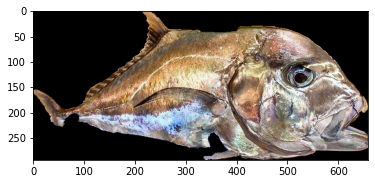

In [16]:
image_path = '/home/fishial/Fishial/dataset/classification/fo_data/data/0dfb19c5-97a8-56c4-9499-7b6f0d58ca44.png'
im = cv2.imread(image_path)
# im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
meta_data, masks = model_segmentation.simple_inference(im)
for mask in masks:
    output = model_classifier.batch_inference([mask], top_k=6)
    print(output)
    plt.imshow(mask)
    plt.show()
# 